# RCNN Paddy Pests Detection

In [1]:
import os
import cv2
import time
import pickle
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from bs4 import BeautifulSoup
from imutils import paths
from google.colab import files
from google.colab.patches import cv2_imshow
from matplotlib.image import imread
from tensorflow.io import read_file
from tensorflow.data import Dataset
from tensorflow.image import decode_jpeg, convert_image_dtype
from tensorflow.keras.applications import DenseNet201, InceptionV3, ResNet50V2, Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import cufflinks as cf
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# cf.go_offline()
pio.renderers.default = 'colab'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!git status

## Cleaning dataset

In [ ]:
def compute_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])

	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the intersection area
	iou = interArea / float(boxAArea + boxBArea - interArea)

	# return the intersection over union value
	return iou

In [ ]:
# loop over the output positive and negative directories
for dirPath in (os.path.join(data_dir, 'pests'), os.path.join(data_dir, 'no pests')):
	# if the output directory does not exist yet, create it
	if not os.path.exists(dirPath):
		os.makedirs(dirPath)

# grab all image paths in the input images directory
imagePaths = list(paths.list_images(os.path.join(data_dir, 'padi berhama')))

# initialize the total number of positive and negative images we have
# saved to disk so far
totalPositive = 0
totalNegative = 0

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# show a progress report
	print("[INFO] processing image {}/{}...".format(i + 1,
		len(imagePaths)))

	# extract the filename from the file path and use it to derive
	# the path to the XML annotation file
	filename = imagePath.split(os.path.sep)[-1]
	filename = filename[:filename.rfind(".")]
	annotPath = os.path.sep.join([os.path.join(data_dir, 'annot'), "{}.xml".format(filename)])

	# load the annotation file, build the soup, and initialize our
	# list of ground-truth bounding boxes
	contents = open(annotPath).read()
	soup = BeautifulSoup(contents, "html.parser")
	gtBoxes = []

	# extract the image dimensions
	w = int(soup.find("width").string)
	h = int(soup.find("height").string)

	# loop over all 'object' elements
	for o in soup.find_all("object"):
		# extract the label and bounding box coordinates
		label = o.find("name").string
		xMin = int(o.find("xmin").string)
		yMin = int(o.find("ymin").string)
		xMax = int(o.find("xmax").string)
		yMax = int(o.find("ymax").string)

		# truncate any bounding box coordinates that may fall
		# outside the boundaries of the image
		xMin = max(0, xMin)
		yMin = max(0, yMin)
		xMax = min(w, xMax)
		yMax = min(h, yMax)

		# update our list of ground-truth bounding boxes
		gtBoxes.append((xMin, yMin, xMax, yMax))

	# load the input image from disk
	image = cv2.imread(imagePath)

	# run selective search on the image and initialize our list of
	# proposed boxes
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)
	ss.switchToSelectiveSearchFast()
	rects = ss.process()
	proposedRects= []

	# loop over the rectangles generated by selective search
	for (x, y, w, h) in rects:
		# convert our bounding boxes from (x, y, w, h) to (startX,
		# startY, startX, endY)
		proposedRects.append((x, y, x + w, y + h))

	# initialize counters used to count the number of positive and
	# negative ROIs saved thus far
	positiveROIs = 0
	negativeROIs = 0

	# loop over the maximum number of region proposals
	for proposedRect in proposedRects[:2000]:
		# unpack the proposed rectangle bounding box
		(propStartX, propStartY, propEndX, propEndY) = proposedRect

		# loop over the ground-truth bounding boxes
		for gtBox in gtBoxes:
			# compute the intersection over union between the two
			# boxes and unpack the ground-truth bounding box
			iou = compute_iou(gtBox, proposedRect)
			(gtStartX, gtStartY, gtEndX, gtEndY) = gtBox

			# initialize the ROI and output path
			roi = None
			outputPath = None

			# check to see if the IOU is greater than 70% *and* that
			# we have not hit our positive count limit
			if iou > 0.7 and positiveROIs <= 30:
				# extract the ROI and then derive the output path to
				# the positive instance
				roi = image[propStartY:propEndY, propStartX:propEndX]
				filename = "{}.png".format(totalPositive)
				outputPath = os.path.join(data_dir, 'pests', filename)

				# increment the positive counters
				positiveROIs += 1
				totalPositive += 1

			# determine if the proposed bounding box falls *within*
			# the ground-truth bounding box
			fullOverlap = propStartX >= gtStartX
			fullOverlap = fullOverlap and propStartY >= gtStartY
			fullOverlap = fullOverlap and propEndX <= gtEndX
			fullOverlap = fullOverlap and propEndY <= gtEndY

			# check to see if there is not full overlap *and* the IoU
			# is less than 5% *and* we have not hit our negative
			# count limit
			if not fullOverlap and iou < 0.05 and \
				negativeROIs <= 10:
				# extract the ROI and then derive the output path to
				# the negative instance
				roi = image[propStartY:propEndY, propStartX:propEndX]
				filename = "{}.png".format(totalNegative)
				outputPath = os.path.join(data_dir, 'no pests', filename)

				# increment the negative counters
				negativeROIs += 1
				totalNegative += 1

			# check to see if both the ROI and output path are valid
			if roi is not None and outputPath is not None:
				# resize the ROI to the input dimensions of the CNN
				# that we'll be fine-tuning, then write the ROI to
				# disk
				roi = cv2.resize(roi, (IMG_SIZE, IMG_SIZE),
					interpolation=cv2.INTER_CUBIC)
				cv2.imwrite(outputPath, roi)

## [Dataset](https://www.kaggle.com/zeeniye/paddy-pests-dataset)

In [ ]:
data_dir = os.path.join(os.getcwd(), 'drive', 'My Drive', 'Colab Notebooks', 'Object Detection', 'datasets')
os.listdir(data_dir)

['padi tanpa hama', 'padi berhama', 'annot', 'pests', 'no pests']

In [ ]:
paddy_w_pests_file = os.listdir(data_dir + '/pests')
paddy_wo_pests_file = os.listdir(data_dir + '/no pests')

w_pests_len = len(paddy_w_pests_file)
wo_pests_len = len(paddy_wo_pests_file)

print(f'{w_pests_len} paddy with pests images')
print(f'{wo_pests_len} paddy without pests images')
print(f'{w_pests_len + wo_pests_len} total images')

115 paddy with pests images
280 paddy without pests images
395 total images


In [ ]:
idx = 3

paddy_w_pests_sample = os.path.join(data_dir, 'pests', paddy_w_pests_file[idx])
paddy_wo_pests_sample = os.path.join(data_dir, 'no pests', paddy_wo_pests_file[idx])

paddy_w_pests_img = imread(paddy_w_pests_sample)
paddy_wo_pests_img = imread(paddy_wo_pests_sample)

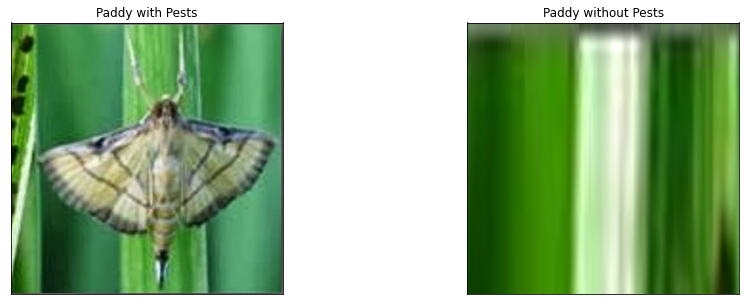

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].imshow(paddy_w_pests_img)
ax[0].set(title='Paddy with Pests', xticks=[], yticks=[])

ax[1].imshow(paddy_wo_pests_img)
ax[1].set(title='Paddy without Pests', xticks=[], yticks=[]);

In [ ]:
paddy_w_pests_img.shape, paddy_wo_pests_img.shape

((512, 512, 3), (512, 512, 3))

In [ ]:
def cek_all_shape(img_file = os.listdir(data_dir + '/padi berhama'), 
                  main_dir = data_dir, the_class = 'padi berhama'):
  '''
  Check all the shapes of available images (dim1,dim2,dim3) with 5 parameters:
  
  * dim1 : list to save all shape dimension 1 (width) of the image
  * dim2 : list to save all shape dimension 1 (height) of the image
  * img_file : the image file path
  * main_dir : the main path for the image (exactly above the subfolders)
  * the_class : the class types
  '''
  dim1 = []
  dim2 = []

  for img in img_file:
    img1 = imread(main_dir + '/' + the_class +'/'+img)
    d1,d2,rgb = img1.shape
    dim1.append(d1)
    dim2.append(d2)

  return dim1, dim2

In [ ]:
dim1, dim2 = cek_all_shape() # Slow running, just to make sure for resize the image 

In [ ]:
d_one = np.mean(dim1)
d_two = np.mean(dim2)
np.median([d_one, d_two])

678.9296296296296

## Preprocessing

In [ ]:
IMG_SIZE = 512 #@param [64, 128, 224, 256, 512, 1024]
BATCH_SIZE = 32 #@param [8, 16, 32, 64]

In [ ]:
# The simple way just use ImageDataGenerator with flow_from_directory method (But it's slower)
def process_images(img_path):
  '''
  Change image into array tensor format
  '''
  image = read_file(img_path)
  image = decode_jpeg(image, channels=3)
  image = convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  
  return image

def create_data(x, batch_size=BATCH_SIZE):
  '''
  Start the images and labels preprocessing
  '''
  data = Dataset.from_tensor_slices(tf.constant(x))
  data = data.map(process_images)

  return data

def get_image_file_label(img_path, img_file, paddy_pest=True):
  '''
  Take raw image files and labels into separate list
  '''
  labels = []
  img_list = [img_path + '/' + i for i in img_file]

  for i in range(len(img_list)):
    labels.append('padi berhama') if paddy_pest else labels.append('padi tanpa hama')

  return img_list, labels

In [ ]:
paddy_w_pests_dir = os.path.join(data_dir, 'pests')
paddy_wo_pests_dir = os.path.join(data_dir, 'no pests')

data1, labels1 = get_image_file_label(paddy_w_pests_dir, paddy_w_pests_file)
data2, labels2 = get_image_file_label(paddy_wo_pests_dir, paddy_wo_pests_file, False)

data = data1 + data2
labels = labels1 + labels2

full_data = create_data(data)

In [ ]:
data = [i for i in full_data.as_numpy_iterator()]

In [ ]:
len(data), type(data), len(labels), type(labels)

(395, list, 395, list)

In [ ]:
labels[139], labels[140]

('padi tanpa hama', 'padi tanpa hama')

In [ ]:
data = np.array(data, dtype='float32')
labels = np.array(labels)

lb = LabelBinarizer()
labels_bin = lb.fit_transform(labels)
labels_bin = to_categorical(labels_bin)

In [ ]:
labels[1], labels_bin[1], labels[-2], labels_bin[-2]

('padi berhama',
 array([1., 0.], dtype=float32),
 'padi tanpa hama',
 array([0., 1.], dtype=float32))

In [ ]:
np.argmax(labels_bin[1]), np.argmax(labels_bin[-2])

(0, 1)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data[:279], labels_bin[:279], test_size=.2, stratify=labels_bin[:279], random_state=42)

len(x_train), len(y_train), len(x_val), len(y_val)

(223, 223, 56, 56)

In [ ]:
def show_9_images(images, labels, max_index=654):
  '''
  Displays 9 images from a data split.
  '''
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 9 (for displaying 9 images)
  pos = 0
  for i in np.random.randint(0, max_index, (9)):
    # Position iterator index
    pos+=1
    # Create subplots (3 rows, 3 columns)
    ax = plt.subplot(3, 3, pos)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(np.argmax(labels[i]))
    # Turn grid lines off
    plt.axis("off")

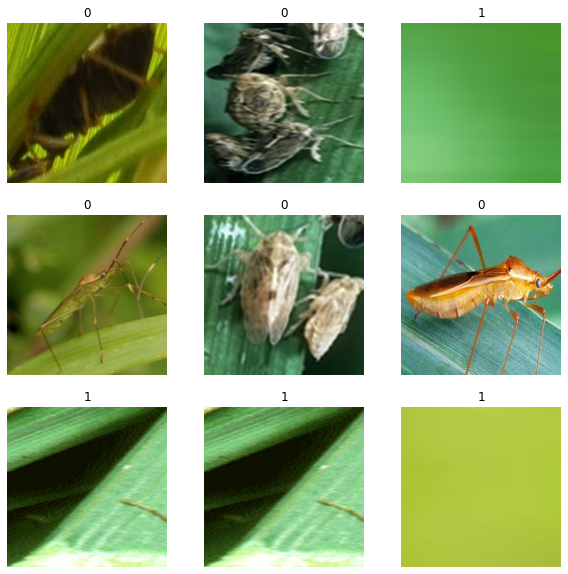

In [ ]:
show_9_images(x_val, y_val, 41);

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15, 
                                   width_shift_range=.01,
                                   height_shift_range=.01,
                                   zoom_range=.1,
                                   shear_range=0.15,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(x_train, y_train,
                               batch_size=BATCH_SIZE)

valid_gen = valid_datagen.flow(x_val, y_val,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

## Modelling

In [ ]:
LR_RATE = 1e-4 
EPOCHS = 20 #@param {type:'slider', min:1, max:100, step:5}

In [ ]:
class custom_callback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')==1.0):
      print("\nReached 100% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = custom_callback()
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min',restore_best_weights=True)
lr_plateau = ReduceLROnPlateau(monitor='val_accuracy', 
                               patience=2,
                               factor=.2, 
                               min_lr=1e-6)

In [ ]:
def create_model(base_model=None, input_shape=(IMG_SIZE,IMG_SIZE,3), optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
  model = Sequential()

  model.add(base_model)

  model.add(GlobalAvgPool2D())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(.5))
  model.add(Dense(2, activation='softmax')) # A little surprise here. If we used 1 output and sigmoid activation, it automatically become continuous

  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  
  return model

In [ ]:
optimizer = Adam(lr=LR_RATE, decay=LR_RATE / EPOCHS)
base_model_inception = InceptionV3(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model_resnet = ResNet50V2(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model_xception = Xception(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model_densenet = DenseNet201(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))

74842112/74836368 [==============================] - 2s 0us/step


Architecture with Transfer Learning

In [ ]:
model_inception = create_model(base_model_inception, optimizer=optimizer)
model_inception.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 14, 14, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 22,065,314
Trainable params: 22,030,882
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
model_resnet = create_model(base_model_resnet, optimizer=optimizer)
model_resnet.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 16, 16, 2048)      23564800  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 258       
Total params: 23,827,330
Trainable params: 23,781,890
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
model_xception = create_model(base_model_xception, optimizer=optimizer)
model_xception.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
Total params: 21,124,010
Trainable params: 21,069,482
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
model_densenet = create_model(base_model_densenet, optimizer=optimizer)
model_densenet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1920)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               245888    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 258       
Total params: 18,568,130
Trainable params: 18,339,074
Non-trainable params: 229,056
_________________________________________________________________


In [ ]:
hist_inception = model_inception.fit(train_gen,
                                     epochs=EPOCHS,
                                     validation_data=valid_gen,
                                     callbacks=[early_stop])

Epoch 1/20
7/7 [==============================] - 12s 2s/step - loss: 0.1581 - accuracy: 0.9462 - val_loss: 4.2406e-05 - val_accuracy: 1.0000
Epoch 2/20
7/7 [==============================] - 11s 2s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 2.2847e-06 - val_accuracy: 1.0000
Epoch 3/20
7/7 [==============================] - 11s 2s/step - loss: 0.0071 - accuracy: 0.9955 - val_loss: 1.8941e-06 - val_accuracy: 1.0000
Epoch 4/20
7/7 [==============================] - 11s 2s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 6.1276e-05 - val_accuracy: 1.0000
Epoch 5/20
7/7 [==============================] - 11s 2s/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.4761e-05 - val_accuracy: 1.0000
Epoch 6/20
7/7 [==============================] - 11s 2s/step - loss: 3.8644e-04 - accuracy: 1.0000 - val_loss: 1.0569e-06 - val_accuracy: 1.0000
Epoch 7/20
7/7 [==============================] - 11s 2s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.2240e-06 - val_accuracy: 1.0000
Ep

In [ ]:
hist_resnet = model_resnet.fit(train_gen,
                               epochs=EPOCHS,
                               validation_data=valid_gen,
                               callbacks=[early_stop])

Epoch 1/20
7/7 [==============================] - 12s 2s/step - loss: 0.2843 - accuracy: 0.8520 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 2/20
7/7 [==============================] - 11s 2s/step - loss: 0.0397 - accuracy: 0.9865 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 3/20
7/7 [==============================] - 11s 2s/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 8.2364e-04 - val_accuracy: 1.0000
Epoch 4/20
7/7 [==============================] - 11s 2s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 6.3712e-06 - val_accuracy: 1.0000
Epoch 5/20
7/7 [==============================] - 11s 2s/step - loss: 0.0189 - accuracy: 0.9955 - val_loss: 0.1216 - val_accuracy: 0.9821
Epoch 6/20
7/7 [==============================] - 11s 2s/step - loss: 0.0373 - accuracy: 0.9865 - val_loss: 0.7323 - val_accuracy: 0.9464
Epoch 7/20
7/7 [==============================] - 11s 2s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0438 - val_accuracy: 0.9821
Epoch 8/20
7/7 [==========

In [ ]:
# Eliminated Architecture
hist_xception = model_xception.fit(train_gen,
                                   epochs=EPOCHS,
                                   validation_data=valid_gen,
                                   callbacks=[early_stop])

Epoch 1/20


ResourceExhaustedError: ignored

In [ ]:
# Eliminated Architecture
hist_densenet = model_densenet.fit(train_gen,
                                   epochs=EPOCHS,
                                   validation_data=valid_gen,
                                   callbacks=[early_stop])

Epoch 1/20


ResourceExhaustedError: ignored

## Evaluation

In [ ]:
def plot_loss(loss_df, acc_df, dataframe, title):
  '''
  Function to plot loss and accuracy of model
  '''
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  fig.suptitle(title)

  loss_df.plot(ax=ax[0])
  ax[0].set(title='Loss', xlabel='Epoch', xticks=range(len(dataframe)))

  acc_df.plot(ax=ax[1])
  ax[1].set(title='Accuracy', xlabel='Epoch', xticks=range(len(dataframe)));

In [ ]:
metricss_inception = pd.DataFrame(hist_inception.history)
metricss_resnet = pd.DataFrame(hist_resnet.history)

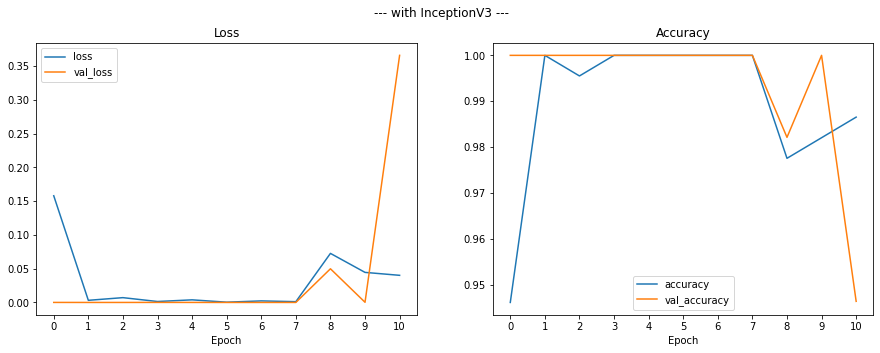

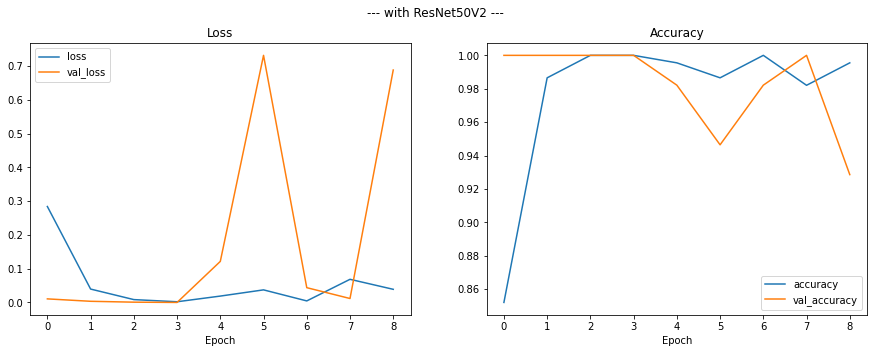

In [ ]:
plot_loss(metricss_inception[['loss', 'val_loss']], 
          metricss_inception[['accuracy', 'val_accuracy']],
          metricss_inception, '--- with InceptionV3 ---')

plot_loss(metricss_resnet[['loss', 'val_loss']], 
          metricss_resnet[['accuracy', 'val_accuracy']],
          metricss_resnet, '--- with ResNet50V2 ---')

In [ ]:
def confusion_matrix_plot(y_val, y_pred, title='Confusion Matrix', cmaps='YlGnBu'):
  '''
  Function to plot confusion matrix
  '''
  plt.figure(figsize=(10,6))
  sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap=cmaps, lw=0.3)
  plt.title(title)
  plt.xlabel('Prediction')
  plt.ylabel('True Label')

In [ ]:
y_val_bin = np.argmax(y_val, axis=1)

In [ ]:
predictions = np.argmax(model_inception.predict(x_val), axis=1)
predictions[:5]

array([1, 0, 0, 0, 1])

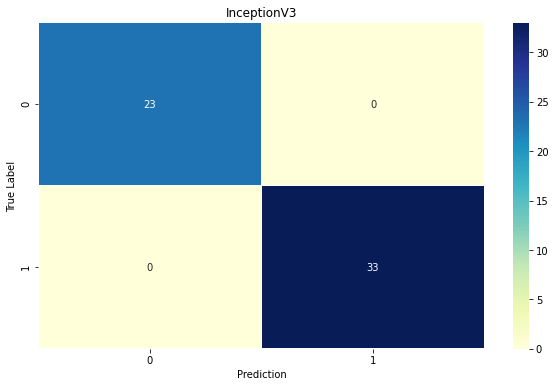

In [ ]:
confusion_matrix_plot(predictions, y_val_bin, 'InceptionV3')

In [ ]:
print(classification_report(y_val_bin, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        33

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



In [ ]:
predictions = np.argmax(model_resnet.predict(x_val), axis=1)
predictions[:5]

array([1, 0, 0, 0, 1])

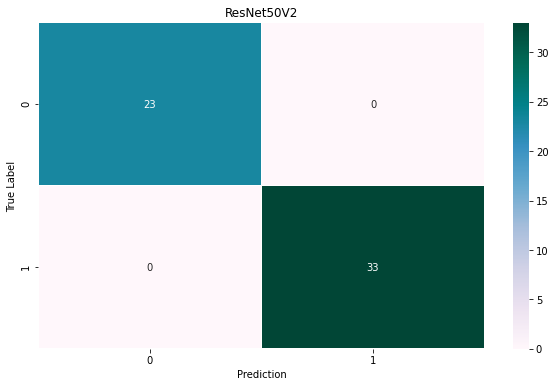

In [ ]:
confusion_matrix_plot(predictions, y_val_bin, 'ResNet50V2', 'PuBuGn')

In [ ]:
print(classification_report(y_val_bin, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        33

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



## Finishing

In [ ]:
full_gen = train_datagen.flow(data[:279], labels_bin[:279],
                              batch_size=BATCH_SIZE)

In [ ]:
model = create_model(base_model_inception, optimizer=optimizer)
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 14, 14, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 258       
Total params: 22,065,314
Trainable params: 22,030,882
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
model.fit(full_gen, epochs=6,
          callbacks=[callbacks])

Epoch 1/6
9/9 [==============================] - 15s 2s/step - loss: 0.1777 - accuracy: 0.9068
Epoch 2/6
9/9 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000
Reached 100% accuracy so cancelling training!
9/9 [==============================] - 13s 1s/step - loss: 0.0043 - accuracy: 1.0000


In [ ]:
# Saving mask detector model
model.save(os.path.join(data_dir[:56], 'rcnn-2.h5'))

In [ ]:
# Saving Label encoder
f = open(os.path.join(data_dir[:56], 'label_encoder.pickle'), 'wb')
f.write(pickle.dumps(lb))
f.close()

## Implementation


In [ ]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes are integers, convert them to floats -- this
	# is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	# compute the area of the bounding boxes and grab the indexes to sort
	# (in the case that no probabilities are provided, simply sort on the
	# bottom-left y-coordinate)
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	# if probabilities are provided, sort on them instead
	if probs is not None:
		idxs = probs

	# sort the indexes
	idxs = np.argsort(idxs)

	# keep looping while some indexes still remain in the indexes list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the index value
		# to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of the bounding
		# box and the smallest (x, y) coordinates for the end of the bounding
		# box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have overlap greater
		# than the provided overlap threshold
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return the indexes of only the bounding boxes to keep
	return pick

In [ ]:
os.path.join(data_dir, 'padi berhama', '00000119.jpg')

'/content/drive/My Drive/Colab Notebooks/Object Detection/datasets/padi berhama/00000119.jpg'

In [ ]:
idxs

(array([], dtype=int64),)

[INFO] loading model and label binarizer...
[INFO] running selective search...
[INFO] proposal shape: (200, 512, 512, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


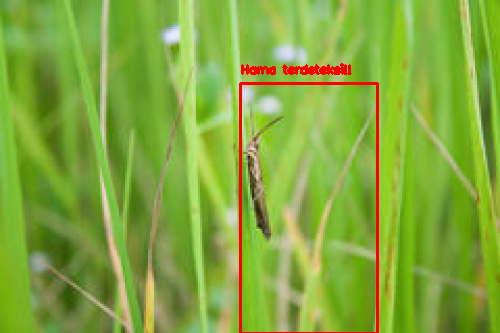

-1

In [ ]:
# load the our fine-tuned model and label binarizer from disk
print("[INFO] loading model and label binarizer...")
model = load_model(os.path.join(data_dir[:56], 'rcnn_paddy_pests.h5'))
lb = pickle.loads(open(os.path.join(data_dir[:56], 'label_encoder.pickle'), 'rb').read())

# # load the input image from disk
# uploaded = files.upload()

# for fn in uploaded.keys():
#   path = fn
#   image = cv2.imread(path, cv2.IMREAD_UNCHANGED)

image = cv2.imread(os.path.join(data_dir, 'padi berhama', '00000284.jpg'), cv2.IMREAD_UNCHANGED)
image = imutils.resize(image, width=500)

# run selective search on the image to generate bounding box proposal
# regions
print("[INFO] running selective search...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []

# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:200]:
  # extract the region from the input image, convert it from BGR to
  # RGB channel ordering, and then resize it to the required input
  # dimensions of our trained CNN
  roi = image[y:y + h, x:x + w]
  roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
  roi = cv2.resize(roi, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)

	# further preprocess by the ROI
  roi = img_to_array(roi)
  roi = preprocess_input(roi)

  # update our proposals and bounding boxes lists
  proposals.append(roi)
  boxes.append((x, y, x + w, y + h))

# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype='float32')
boxes = np.array(boxes, dtype='int32')
print('[INFO] proposal shape: {}'.format(proposals.shape))

# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = model.predict(proposals)

# find the index of all predictions that are positive for the
# "padi berhama" class
print("[INFO] applying NMS...")
# preds_bool = np.argmax(proba, axis=1)
# label = 'padi berhama' if preds_bool == 0 else 'padi tanpa hama'
# color = (0, 255, 0) if label == 'Mask' else (0, 0, 255)

labels = lb.classes_[np.argmax(proba, axis=1)]
idxs = np.where(labels == "padi berhama")[0]

# use the indexes to extract all bounding boxes and associated class
# label probabilities associated with the "padi berhama" class
boxes = boxes[idxs]
proba = proba[idxs][:, 1]
# print('prob', proba)

# further filter indexes by enforcing a minimum prediction
# probability be met
MIN_PROBA = 0.8
idxs = np.where(proba == np.max(proba))
# print('index2', idxs)
boxes = boxes[idxs]
proba = proba[idxs]

# clone the original image so that we can draw on it
clone = image.copy()

# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = box
	cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Before NMS\nHama terdeteksi: {:.2f}%".format(prob * 100)
	cv2.putText(clone, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

# # show the output after *before* running NMS
# cv2_imshow(clone)

# run non-maxima suppression on the bounding boxes
boxIdxs = non_max_suppression(boxes, proba)

# loop over the bounding box indexes
for i in boxIdxs:
  # draw the bounding box, label, and probability on the image
  text= "Hama terdeteksi!!" if proba > .3 else "tidak terdapat hama"
  color = (0, 255, 0) if text == "tidak terdapat hama" else (0, 0, 255)
  (startX, startY, endX, endY) = boxes[i]
  cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  # text= "Hama terdeteksi: {:.2f}%".format(proba[i] * 100)
  cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 2)

# show the output image *after* running NMS
cv2_imshow(image)
cv2.waitKey(0)